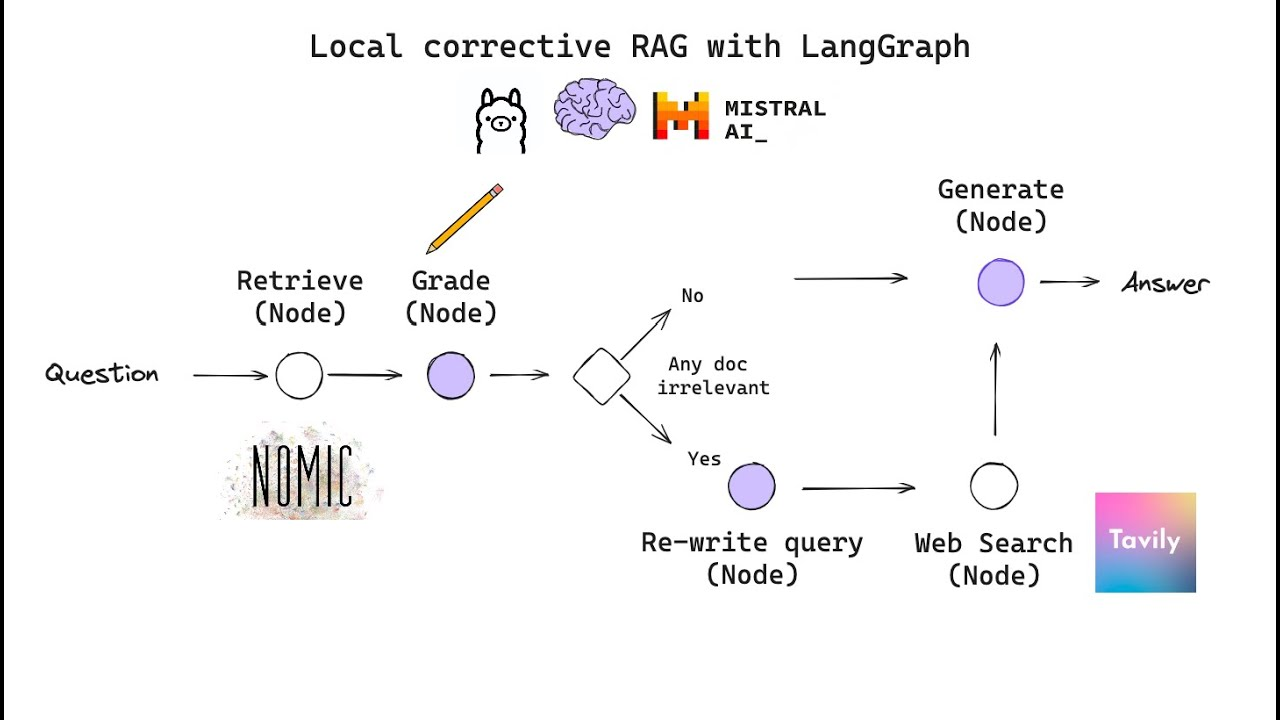

In [1]:
import os 
from dotenv  import load_dotenv
load_dotenv()

GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
os.environ["GOOGLE_API_KEY"] = GEMINI_API_KEY

In [2]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [3]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [4]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

In [5]:
docs = [WebBaseLoader(url).load() for url in urls]

In [6]:
docs

[[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final res

In [7]:
docs_list = [item for sublist in docs for item in sublist]

In [8]:
docs_list

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [9]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)

In [10]:
doc_splits = text_splitter.split_documents(docs_list)

In [11]:
doc_splits

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [12]:
# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings,
)

In [13]:
vectorstore

In [14]:
retriever = vectorstore.as_retriever()

In [15]:
retriever

VectorStoreRetriever(tags=['Chroma', 'GoogleGenerativeAIEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x000001AEB705E190>, search_kwargs={})

In [16]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

In [17]:
# Prompt
prompt = hub.pull("rlm/rag-prompt")

print(f"---PROMPT--- {prompt}")

---PROMPT--- input_variables=['context', 'question'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})]


In [18]:
# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [19]:
# Chain
rag_chain = prompt | llm | StrOutputParser()

In [20]:
rag_chain

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])
| ChatGoogleGenerativeAI(model='models/gemini-1.5-flash', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x000001AEB5C2E8D0>, default_metadata=())
| StrOutputParser()

In [21]:
# Run
question = "tell me about agent memory."

In [22]:
generation = rag_chain.invoke({"context": docs, "question": question})

In [23]:
generation

'LLM-powered autonomous agents use two types of memory: short-term memory, which leverages in-context learning, and long-term memory, which uses an external vector store for information retention and retrieval.  This allows the agent to retain and recall information over extended periods, complementing its ability to process information within the current context.'

In [24]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

d:\a27_YEARS_OLD\langgraph\venv\Lib\site-packages\IPython\core\interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [25]:
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

In [26]:
# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeDocuments)

In [27]:
structured_llm_grader

RunnableBinding(bound=ChatGoogleGenerativeAI(model='models/gemini-1.5-flash', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x000001AEB5C2E8D0>, default_metadata=()), kwargs={'tools': [{'type': 'function', 'function': {'name': 'GradeDocuments', 'description': 'Binary score for relevance check on retrieved documents.', 'parameters': {'type': 'object', 'properties': {'binary_score': {'description': "Documents are relevant to the question, 'yes' or 'no'", 'type': 'string'}}, 'required': ['binary_score']}}}], 'tool_choice': 'GradeDocuments'}, config={}, config_factories=[])
| PydanticToolsParser(first_tool_only=True, tools=[<class '__main__.GradeDocuments'>])

check whether question and retrieve doc are related  yes or no

In [28]:
# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

In [29]:
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

In [30]:
grade_prompt

ChatPromptTemplate(input_variables=['document', 'question'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template="You are a grader assessing relevance of a retrieved document to a user question. \n \n    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n\n    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['document', 'question'], input_types={}, partial_variables={}, template='Retrieved document: \n\n {document} \n\n User question: {question}'), additional_kwargs={})])

In [31]:
retrieval_grader = grade_prompt | structured_llm_grader

In [32]:
retrieval_grader # check whether question and retrieve doc are related  yes or no

ChatPromptTemplate(input_variables=['document', 'question'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template="You are a grader assessing relevance of a retrieved document to a user question. \n \n    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n\n    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['document', 'question'], input_types={}, partial_variables={}, template='Retrieved document: \n\n {document} \n\n User question: {question}'), additional_kwargs={})])
| RunnableBinding(bound=ChatGoogleGenerativeAI(model='models/gemini-1.5-flash', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeSe

In [33]:
question = "tell me about the agent memory."

In [34]:
docs = retriever.get_relevant_documents(question)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_18656\10663643.py:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question)


In [35]:
docs

[Document(metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context learning (See Prompt Engineering) as utiliz

In [36]:
doc_txt = docs[1].page_content

In [37]:
doc_txt

'Each element is an observation, an event directly provided by the agent.\n- Inter-agent communication can trigger new natural language statements.\n\n\nRetrieval model: surfaces the context to inform the agent’s behavior, according to relevance, recency and importance.\n\nRecency: recent events have higher scores\nImportance: distinguish mundane from core memories. Ask LM directly.\nRelevance: based on how related it is to the current situation / query.\n\n\nReflection mechanism: synthesizes memories into higher level inferences over time and guides the agent’s future behavior. They are higher-level summaries of past events (<- note that this is a bit different from self-reflection above)\n\nPrompt LM with 100 most recent observations and to generate 3 most salient high-level questions given a set of observations/statements. Then ask LM to answer those questions.\n\n\nPlanning & Reacting: translate the reflections and the environment information into actions'

In [38]:
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


In [39]:
question1 = "tell me about the Tajmahal."

In [40]:
doc_txt = docs[1].page_content

In [41]:
doc_txt

'Each element is an observation, an event directly provided by the agent.\n- Inter-agent communication can trigger new natural language statements.\n\n\nRetrieval model: surfaces the context to inform the agent’s behavior, according to relevance, recency and importance.\n\nRecency: recent events have higher scores\nImportance: distinguish mundane from core memories. Ask LM directly.\nRelevance: based on how related it is to the current situation / query.\n\n\nReflection mechanism: synthesizes memories into higher level inferences over time and guides the agent’s future behavior. They are higher-level summaries of past events (<- note that this is a bit different from self-reflection above)\n\nPrompt LM with 100 most recent observations and to generate 3 most salient high-level questions given a set of observations/statements. Then ask LM to answer those questions.\n\n\nPlanning & Reacting: translate the reflections and the environment information into actions'

In [42]:
docs1 = retriever.get_relevant_documents(question1)

In [43]:
docs1

[Document(metadata={'description': 'The use of large language models in the real world has strongly accelerated by the launch of ChatGPT. We (including my team at OpenAI, shoutout to them) have invested a lot of effort to build default safe behavior into the model during the alignment process (e.g. via RLHF). However, adversarial attacks or jailbreak prompts could potentially trigger the model to output something undesired.\nA large body of ground work on adversarial attacks is on images, and differently it operates in the continuous, high-dimensional space. Attacks for discrete data like text have been considered to be a lot more challenging, due to lack of direct gradient signals. My past post on Controllable Text Generation is quite relevant to this topic, as attacking LLMs is essentially to control the model to output a certain type of (unsafe) content.', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/', 'title': "Adversarial Attacks on LL

In [44]:
doc_txt = docs[1].page_content

In [45]:
doc_txt

'Each element is an observation, an event directly provided by the agent.\n- Inter-agent communication can trigger new natural language statements.\n\n\nRetrieval model: surfaces the context to inform the agent’s behavior, according to relevance, recency and importance.\n\nRecency: recent events have higher scores\nImportance: distinguish mundane from core memories. Ask LM directly.\nRelevance: based on how related it is to the current situation / query.\n\n\nReflection mechanism: synthesizes memories into higher level inferences over time and guides the agent’s future behavior. They are higher-level summaries of past events (<- note that this is a bit different from self-reflection above)\n\nPrompt LM with 100 most recent observations and to generate 3 most salient high-level questions given a set of observations/statements. Then ask LM to answer those questions.\n\n\nPlanning & Reacting: translate the reflections and the environment information into actions'

In [46]:
print(retrieval_grader.invoke({"question": question1, "document": doc_txt}))

binary_score='no'


In [47]:
### Question Re-writer
# Prompt
from langchain_core.prompts import ChatPromptTemplate

rephrase the question

In [48]:
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""

In [49]:
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

In [50]:
question_rewriter = re_write_prompt | llm | StrOutputParser()

In [51]:
question_rewriter

ChatPromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='You a question re-writer that converts an input question to a better version that is optimized \n \n     for web search. Look at the input and try to reason about the underlying semantic intent / meaning.'), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, template='Here is the initial question: \n\n {question} \n Formulate an improved question.'), additional_kwargs={})])
| ChatGoogleGenerativeAI(model='models/gemini-1.5-flash', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x000001AEB5C2E8D0>, default_metadata=())
| StrOutputParser()

In [52]:
question_rewriter.invoke({"question": question})

'What is agent memory in artificial intelligence?'

In [53]:
def retrieve(state): # first retriever call 
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
    
    """
    print("---RETRIEVE---")
    
    question = state["question"]
    
    documents = retriever.get_relevant_documents(question)
    
    return {"documents": documents, "question": question} # retrun pass to grade_document()

In [54]:
def grade_documents(state): # call after retrieving documents , grade document as agent
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    
    print("---CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT---")
    
    question = state["question"]
    
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    
    web_search = "No"
    
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes": # return pass to generate() rag chain
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:  # return pass to transform_query()
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search} 

In [57]:
def transform_query(state): # call transform_query after grade no, not related to question , call for web search
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """
    print("---TRANSFORM QUERY---")
    
    question = state["question"]
    
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question}) # Re-write question for web search suitable 
    
    return {"documents": documents, "question": better_question} # return pass to web_search()

In [56]:
def generate(state): # generate final response
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    
    print("---GENERATE---")
    
    question = state["question"]
    documents = state["documents"]
    
    generation = rag_chain.invoke({"context": documents, "question": question})
    
    return {"documents": documents, "question": question, "generation": generation}

In [58]:
## Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

In [59]:
from langchain.schema import Document

In [60]:
def web_search(state): # call web_search
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """
    print("---WEB SEARCH---")
    
    question = state["question"]
    
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    
    web_results = "\n".join([d["content"] for d in docs])
    
    web_results = Document(page_content=web_results)
    
    documents.append(web_results)

    return {"documents": documents, "question": question} # retrun pass to generate()

In [61]:
def decide_to_generate(state): # generate final response
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [62]:
from langgraph.graph import END, StateGraph, START

In [63]:
from typing import List

from typing_extensions import TypedDict

class State(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]

workflow= StateGraph(State)

In [64]:
# define the nodes
# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search_node", web_search)  # web search

In [65]:
# Build graph
workflow.add_edge(START, "retrieve")

workflow.add_edge("retrieve", "grade_documents")

workflow.add_conditional_edges("grade_documents", decide_to_generate, {"transform_query": "transform_query","generate": "generate",}),

workflow.add_edge("transform_query", "web_search_node")

workflow.add_edge("web_search_node", "generate")

workflow.add_edge("generate", END)

In [66]:
# Compile
app = workflow.compile()

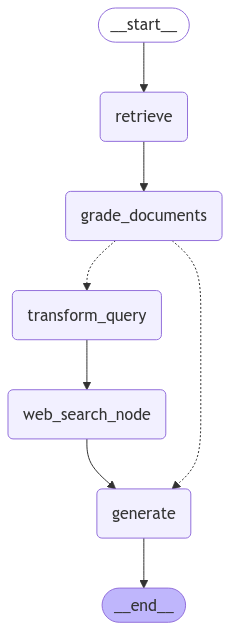

In [67]:
app

In [68]:
from pprint import pprint

# Run
inputs = {"question": "tell me about the agent memory."}

In [69]:
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")
# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('Agent memory includes short-term memory, utilizing in-context learning, and '
 'long-term memory, often leveraging an external vector store for information '
 'retention and retrieval.  This allows agents to learn from past actions and '
 'retain information over extended periods.  The long-term memory enables the '
 "agent to recall information that's not readily available in the model's "
 'context window.')
